# Initial Modelling
We are going to make some basic models to predict both Min and Max demands for a day using findings from the EDA phase of the projects.
Models will start simple using a few datasets to predict and then get more complex.
Models will be using RMSE and MAE to evaluate and compare.

In [1]:
# Import general packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Load Data and Format for Modelling
To begin with we will load in the:
- Total Demand Dataset
- NSW Temperature Dataset
- NSW Residential Solar Data
- NSW Population Data

Seeing as the Residential Solar Data only goes up to 2020 and Demand Data is only from 2010, when doing the train test split data from 2010-2018 will be used for training, 2019 and 2020 will be used for test. Other data will be discarded for now.

Data that have recording interval periods greater than 1 day will be linearly interpolated for now for simplicity.

In [2]:
# Import demand dataset
demand_df = pd.read_csv('../data/raw/totaldemand_nsw.csv', names=['datetime', 'region', 'demand'], header=0)
demand_df['datetime'] = pd.to_datetime(demand_df['datetime'])
demand_df = demand_df.resample('D', on='datetime')['demand'].agg(['min', 'max'])
demand_df.rename(columns={'min':'demand_min', 'max':'demand_max'}, inplace=True)
demand_df.head()

,demand_min,demand_max
datetime,,
2010-01-01,6157.36,8922.42
2010-01-02,6112.73,9326.64
2010-01-03,6014.91,8277.85
2010-01-04,6023.79,9522.30
2010-01-05,6287.12,10728.72


In [3]:
# Import temperature data
temp_df = pd.read_csv('../data/raw/temperature_nsw.csv', names=['datetime', 'location', 'temp'], header=0)
temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
temp_df.drop(temp_df[temp_df['temp'] <= -9999].index, inplace = True)
temp_df = temp_df.resample('D', on='datetime')['temp'].agg(['min', 'max', 'mean'])
temp_df.rename(columns={'min':'temp_min', 'max':'temp_max', 'mean':'temp_mean'}, inplace=True)
temp_df.head()

,temp_min,temp_max,temp_mean
datetime,,,
2010-01-01,22.1,28.8,25.094000
2010-01-02,21.6,29.4,24.765385
2010-01-03,17.9,21.5,19.429825
2010-01-04,17.9,23.9,20.625926
2010-01-05,15.4,27.7,22.660417


In [4]:
# Import solar data
solar_df = pd.read_csv('../data/raw/nsw_residential_solar.csv', names=['datetime', 'units', 'cum_units', 'output', 'cum_output'], header=0)
solar_df['datetime'] = pd.to_datetime(solar_df['datetime'])
# Interpolate to get daily data
solar_df = solar_df.set_index('datetime').resample('D', convention='end').interpolate(method='linear')
solar_df.head()

,units,cum_units,output,cum_output
datetime,,,,
2008-01-01,127.000000,1882.000000,287.946000,2710.745000
2008-01-02,128.451613,1887.548387,286.983677,2719.071258
2008-01-03,129.903226,1893.096774,286.021355,2727.397516
2008-01-04,131.354839,1898.645161,285.059032,2735.723774
2008-01-05,132.806452,1904.193548,284.096710,2744.050032


In [5]:
# Import population data
pop_df = pd.read_csv('../data/raw/NSW_population.csv', usecols=['TIME_PERIOD: Time Period', 'OBS_VALUE'], header=0)
pop_df.rename(columns={'TIME_PERIOD: Time Period':'datetime', 'OBS_VALUE':'population'}, inplace=True)
pop_df['datetime'] = pd.to_datetime(pop_df['datetime'], format='%Y')
pop_df.head()
pop_df = pop_df.set_index('datetime').resample('D', convention='start').interpolate(method='linear')
pop_df.head()

,population
datetime,
2001-01-01,6.530349e+06
2001-01-02,6.530487e+06
2001-01-03,6.530625e+06
2001-01-04,6.530764e+06
2001-01-05,6.530902e+06


In [6]:
# Merge data frames and split into train/test sets. Start with untransformed data then add models with transformations eg sqrt(temp), ln(solar output)
full_df = demand_df.merge(temp_df, on='datetime', how='outer')
full_df = full_df.merge(solar_df, on='datetime', how='outer')
full_df = full_df.merge(pop_df, on='datetime', how='outer')
full_df.sort_index(inplace=True)
full_df.head()

,demand_min,demand_max,temp_min,temp_max,temp_mean,units,cum_units,output,cum_output,population
datetime,,,,,,,,,,
2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.530349e+06
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.530487e+06
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.530625e+06
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.530764e+06
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.530902e+06


In [7]:
# Filter dataframe and split into train-test sets
train_mask = (full_df.index >= '2010-01-01') & (full_df.index < '2019-01-01')
test_mask = (full_df.index >= '2019-01-01') & (full_df.index < '2020-12-01') # interpolation didn't fill to the end of 2020 for solar_df

train_df = full_df[train_mask]
test_df = full_df[test_mask]

In [8]:
# Output bounded full df
bounds_mask = (full_df.index >= '2010-01-01') & (full_df.index < '2020-12-01')
full_df[bounds_mask].to_csv('../data/raw/all_data.csv')

In [9]:
train_df

,demand_min,demand_max,temp_min,temp_max,temp_mean,units,cum_units,output,cum_output,population
datetime,,,,,,,,,,
2010-01-01,6157.36,8922.42,22.1,28.8,25.094000,1790.000000,21518.000000,2767.019000,3.036293e+04,7.144292e+06
2010-01-02,6112.73,9326.64,21.6,29.4,24.765385,1810.677419,21596.419355,2811.171258,3.049634e+04,7.144495e+06
2010-01-03,6014.91,8277.85,17.9,21.5,19.429825,1831.354839,21674.838710,2855.323516,3.062975e+04,7.144699e+06
2010-01-04,6023.79,9522.30,17.9,23.9,20.625926,1852.032258,21753.258065,2899.475774,3.076316e+04,7.144902e+06
2010-01-05,6287.12,10728.72,15.4,27.7,22.660417,1872.709677,21831.677419,2943.628032,3.089657e+04,7.145106e+06
...,...,...,...,...,...,...,...,...,...,...
2018-12-27,6001.25,11050.31,17.9,32.1,23.083077,4677.258065,485574.903226,34342.086194,1.972439e+06,8.033090e+06
2018-12-28,6269.06,11347.41,19.0,33.6,26.010417,4624.806452,485717.322581,33666.076355,1.973437e+06,8.033333e+06
2018-12-29,6306.77,10910.29,18.6,33.9,25.675000,4572.354839,485859.741935,32990.066516,1.974436e+06,8.033576e+06


In [10]:
test_df

,demand_min,demand_max,temp_min,temp_max,temp_mean,units,cum_units,output,cum_output,population
datetime,,,,,,,,,,
2019-01-01,6162.55,10674.41,21.7,32.8,26.456863,4415.000000,486287.000000,30962.037000,1.977433e+06,8.034305e+06
2019-01-02,6412.74,10978.13,21.3,28.9,23.941667,4460.709677,486475.129032,31341.130548,1.978810e+06,8.034469e+06
2019-01-03,6487.59,10593.87,21.6,27.2,23.968750,4506.419355,486663.258065,31720.224097,1.980188e+06,8.034634e+06
2019-01-04,6450.30,11916.46,19.0,29.8,24.429630,4552.129032,486851.387097,32099.317645,1.981566e+06,8.034798e+06
2019-01-05,6692.19,10882.52,19.3,37.9,23.664865,4597.838710,487039.516129,32478.411194,1.982944e+06,8.034963e+06
...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6051.38,10871.75,14.8,32.5,22.887500,11807.666667,677597.833333,110116.752667,3.490182e+06,8.093864e+06
2020-11-27,6152.19,10173.41,18.6,26.3,21.774510,11792.333333,677988.866667,110417.842533,3.493903e+06,8.093863e+06
2020-11-28,6284.18,12421.83,18.3,40.4,30.079167,11777.000000,678379.900000,110718.932400,3.497624e+06,8.093862e+06


## Linear Regression Models
Now that we have all the data entered, let's build some preliminary linear regression models
- untransformed models
    - add normalisation
- transformed models with normalisation
- add in interactions between variables e.g. temp-solaroutput
... later look at other ML algorithms and data that could improve model

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [12]:
lm1_min = smf.ols('demand_min ~ temp_min + temp_max + np.log(cum_output) + np.log(population)', data = train_df).fit()
lm1_max = smf.ols('demand_max ~ temp_min + temp_max + np.log(cum_output) + np.log(population)', data = train_df).fit()

In [13]:
lm1_min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             demand_min   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     317.4
Date:                Mon, 27 Mar 2023   Prob (F-statistic):          4.28e-231
Time:                        14:14:27   Log-Likelihood:                -24081.
No. Observations:                3284   AIC:                         4.817e+04
Df Residuals:                    3279   BIC:                         4.820e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.873e+04   6136.304     -4.681      0.000   -4.08e+04   -1.67e+04
temp_min             -26.6785      1.671    -15.962      0.000     -29.956     -23.401
temp_max              -9.7389      1.761     -5.531      0.000     -13.191      -6.287
np.log(cum_output)  -257.1365     15.975    -16.096      0.000    -288.458    -225.815
np.log(population)  2459.0646    399.516      6.155      0.000    1675.738    3242.391
==============================================================================
Omnibus:                      175.582   Durbin-Watson:                   0.366
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.209
Skew:                           0.501   Prob(JB):                     3.09e-52
Kurtosis:                       3.855   Cond. No.                     3.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
lm1_max.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             demand_max   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     136.2
Date:                Mon, 27 Mar 2023   Prob (F-statistic):          8.61e-108
Time:                        14:14:27   Log-Likelihood:                -27652.
No. Observations:                3284   AIC:                         5.531e+04
Df Residuals:                    3279   BIC:                         5.534e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -4.881e+04   1.82e+04     -2.682      0.007   -8.45e+04   -1.31e+04
temp_min             -73.7257      4.958    -14.871      0.000     -83.446     -64.006
temp_max              25.9312      5.222      4.965      0.000      15.692      36.171
np.log(cum_output)  -524.1588     47.384    -11.062      0.000    -617.064    -431.254
np.log(population)  4158.2885   1185.024      3.509      0.000    1834.826    6481.751
==============================================================================
Omnibus:                      217.439   Durbin-Watson:                   0.506
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              278.677
Skew:                           0.610   Prob(JB):                     3.06e-61
Kurtosis:                       3.739   Cond. No.                     3.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# Calc RMSE for model for min model 1
np.sqrt(mean_squared_error(test_df['demand_min'],lm1_min.predict(test_df)))

451.56744733747433

In [16]:
# Calc RMSE for model for max model 1
np.sqrt(mean_squared_error(test_df['demand_max'],lm1_max.predict(test_df)))

1256.507859296469

In [17]:
# Create day/month/year variables
train_df['day'] = train_df.index.to_series().dt.day.values
train_df['month'] = train_df.index.to_series().dt.month.values
train_df['year'] = train_df.index.to_series().dt.year.values

test_df['day'] = test_df.index.to_series().dt.day.values
test_df['month'] = test_df.index.to_series().dt.month.values
test_df['year'] = test_df.index.to_series().dt.year.values

C:\Users\sambo\AppData\Local\Temp\ipykernel_28096\17397179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['day'] = train_df.index.to_series().dt.day.values
C:\Users\sambo\AppData\Local\Temp\ipykernel_28096\17397179.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['month'] = train_df.index.to_series().dt.month.values
C:\Users\sambo\AppData\Local\Temp\ipykernel_28096\17397179.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [18]:
lm2_min = smf.ols('demand_min ~ (temp_min)*(temp_max) * np.log(cum_output) + np.log(population) + day * month * year', data = train_df).fit()
lm2_max = smf.ols('demand_max ~ (temp_min)*(temp_max) * np.log(cum_output) + np.log(population) + day * month * year', data = train_df).fit()

In [19]:
lm2_min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             demand_min   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     283.9
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:14:27   Log-Likelihood:                -23249.
No. Observations:                3284   AIC:                         4.653e+04
Df Residuals:                    3268   BIC:                         4.663e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             1.118e+05   8.11e+04      1.379      0.168   -4.72e+04    2.71e+05
temp_min                              -231.8738     66.653     -3.479      0.001    -362.560    -101.187
temp_max                              -231.3926     49.419     -4.682      0.000    -328.289    -134.496
temp_min:temp_max                        9.5030      2.949      3.222      0.001       3.720      15.286
np.log(cum_output)                    -336.0697     75.956     -4.425      0.000    -484.996    -187.144
temp_min:np.log(cum_output)              0.6582      4.974      0.132      0.895      -9.093      10.410
temp_max:np.log(cum_output)              7.1940      3.680      1.955      0.051      -0.021      14.409
temp_min:temp_max:np.log(cum_output)    -0.0436      0.220     -0.198      0.843      -0.475       0.388
np.log(population)                    1.071e+04   5667.117      1.890      0.059    -400.227    2.18e+04
day                                   1480.6355    962.563      1.538      0.124    -406.652    3367.923
month                                  583.9557   2418.611      0.241      0.809   -4158.192    5326.103
day:month                             -196.4265    129.755     -1.514      0.130    -450.836      57.983
year                                  -132.8363     84.269     -1.576      0.115    -298.062      32.389
day:year                                -0.7325      0.478     -1.533      0.125      -1.670       0.205
month:year                              -0.2955      1.201     -0.246      0.806      -2.649       2.058
day:month:year                           0.0971      0.064      1.507      0.132      -0.029       0.223
==============================================================================
Omnibus:                       18.717   Durbin-Watson:                   0.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.051
Skew:                           0.130   Prob(JB):                     2.68e-05
Kurtosis:                       3.293   Cond. No.                     4.39e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
lm2_max.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             demand_max   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     350.4
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:14:27   Log-Likelihood:                -26330.
No. Observations:                3284   AIC:                         5.269e+04
Df Residuals:                    3268   BIC:                         5.279e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             6.683e+05   2.07e+05      3.223      0.001    2.62e+05    1.07e+06
temp_min                              -384.7535    170.338     -2.259      0.024    -718.733     -50.774
temp_max                              -531.9715    126.295     -4.212      0.000    -779.598    -284.346
temp_min:temp_max                       19.6491      7.537      2.607      0.009       4.871      34.427
np.log(cum_output)                    -296.0667    194.111     -1.525      0.127    -676.659      84.525
temp_min:np.log(cum_output)            -28.1812     12.710     -2.217      0.027     -53.102      -3.260
temp_max:np.log(cum_output)              8.9273      9.404      0.949      0.343      -9.510      27.365
temp_min:temp_max:np.log(cum_output)     0.8625      0.562      1.535      0.125      -0.239       1.964
np.log(population)                    5.008e+04   1.45e+04      3.458      0.001    2.17e+04    7.85e+04
day                                   3767.6683   2459.905      1.532      0.126   -1055.443    8590.779
month                                  166.0306   6180.950      0.027      0.979    -1.2e+04    1.23e+04
day:month                             -302.0507    331.599     -0.911      0.362    -952.214     348.113
year                                  -713.9217    215.356     -3.315      0.001   -1136.169    -291.675
day:year                                -1.8652      1.221     -1.527      0.127      -4.260       0.530
month:year                              -0.1226      3.068     -0.040      0.968      -6.138       5.893
day:month:year                           0.1490      0.165      0.905      0.365      -0.174       0.472
==============================================================================
Omnibus:                        4.499   Durbin-Watson:                   0.999
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.697
Skew:                           0.052   Prob(JB):                       0.0955
Kurtosis:                       3.154   Cond. No.                     4.39e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# Calc RMSE for model for min model 2
np.sqrt(mean_squared_error(test_df['demand_min'],lm2_min.predict(test_df)))

424.9391030752395

In [22]:
# Calc RMSE for model for max model 2
np.sqrt(mean_squared_error(test_df['demand_max'],lm2_max.predict(test_df)))

1197.1213689273125

We can see a large improvement in the R^2 values in the new model, but little change in the performance of the model in terms of RMSE

In [23]:
lm3_min = smf.ols('demand_min ~ (temp_min) * I(temp_min**2) * (temp_max) * I(temp_max**2) * np.log(cum_output) + np.log(population) + day * month * year', data = train_df).fit()
lm3_max = smf.ols('demand_max ~ (temp_min) * I(temp_min**2) * (temp_max) * I(temp_max**2) * np.log(cum_output) + np.log(population) + day * month * year', data = train_df).fit()

In [24]:
lm3_min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             demand_min   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     131.7
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:14:27   Log-Likelihood:                -23060.
No. Observations:                3284   AIC:                         4.620e+04
Df Residuals:                    3244   BIC:                         4.644e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                2.61e+05    9.2e+04      2.837      0.005    8.07e+04    4.41e+05
temp_min                                                               -2.119e+04   1.08e+04     -1.970      0.049   -4.23e+04    -101.748
I(temp_min ** 2)                                                        1721.1786    833.180      2.066      0.039      87.566    3354.792
temp_min:I(temp_min ** 2)                                                -45.0489     22.199     -2.029      0.043     -88.574      -1.524
temp_max                                                               -1.648e+04   7628.819     -2.161      0.031   -3.14e+04   -1526.902
temp_min:temp_max                                                       3103.1014   1565.806      1.982      0.048      33.032    6173.171
I(temp_min ** 2):temp_max                                               -233.8287    112.652     -2.076      0.038    -454.706     -12.952
temp_min:I(temp_min ** 2):temp_max                                         5.8010      2.791      2.079      0.038       0.329      11.273
I(temp_max ** 2)                                                         839.0999    390.581      2.148      0.032      73.289    1604.910
temp_min:I(temp_max ** 2)                                               -154.5457     75.729     -2.041      0.041    -303.027      -6.064
I(temp_min ** 2):I(temp_max ** 2)                                         10.8714      5.084      2.138      0.033       0.902      20.840
temp_min:I(temp_min ** 2):I(temp_max ** 2)                                -0.2556      0.118     -2.173      0.030      -0.486      -0.025
temp_max:I(temp_max ** 2)                                                -14.5855      6.591     -2.213      0.027     -27.509      -1.662
temp_min:temp_max:I(temp_max ** 2)                                         2.6565      1.217      2.182      0.029       0.269       5.044
I(temp_min ** 2):temp_max:I(temp_max ** 2)                                -0.1769      0.077     -2.300      0.021      -0.328      -0.026
temp_min:I(temp_min ** 2):temp_max:I(temp_max ** 2)                        0.0040      0.002      2.374      0.018       0.001       0.007
np.log(cum_output)                                                     -8935.1335   3666.570     -2.437      0.015   -1.61e+04   -1746.106
temp_min:np.log(cum_output)                                             1735.2342    808.039      2.147      0.032     150.916    3319.552
I(temp_min ** 2):np.log(cum_output)                                     -137.3818     62.993     -2.181      0.029    -260.891     -13.873
temp_min:I(temp_min ** 2)

In [25]:
lm3_max.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             demand_max   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     166.4
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:14:27   Log-Likelihood:                -26100.
No. Observations:                3284   AIC:                         5.228e+04
Df Residuals:                    3244   BIC:                         5.252e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               7.351e+05   2.32e+05      3.166      0.002     2.8e+05    1.19e+06
temp_min                                                                1.385e+04   2.71e+04      0.510      0.610   -3.94e+04    6.71e+04
I(temp_min ** 2)                                                       -1738.3624   2102.596     -0.827      0.408   -5860.912    2384.187
temp_min:I(temp_min ** 2)                                                 65.1079     56.021      1.162      0.245     -44.731     174.947
temp_max                                                                3838.6920   1.93e+04      0.199      0.842   -3.39e+04    4.16e+04
temp_min:temp_max                                                      -2005.3678   3951.434     -0.508      0.612   -9752.926    5742.191
I(temp_min ** 2):temp_max                                                230.6877    284.287      0.811      0.417    -326.713     788.089
temp_min:I(temp_min ** 2):temp_max                                        -8.1187      7.043     -1.153      0.249     -21.928       5.690
I(temp_max ** 2)                                                        -219.6297    985.662     -0.223      0.824   -2152.212    1712.953
temp_min:I(temp_max ** 2)                                                 86.2985    191.108      0.452      0.652    -288.407     461.004
I(temp_min ** 2):I(temp_max ** 2)                                         -9.2630     12.831     -0.722      0.470     -34.420      15.894
temp_min:I(temp_min ** 2):I(temp_max ** 2)                                 0.3115      0.297      1.049      0.294      -0.271       0.894
temp_max:I(temp_max ** 2)                                                  3.2269     16.634      0.194      0.846     -29.388      35.841
temp_min:temp_max:I(temp_max ** 2)                                        -1.0589      3.072     -0.345      0.730      -7.083       4.965
I(temp_min ** 2):temp_max:I(temp_max ** 2)                                 0.1084      0.194      0.558      0.577      -0.272       0.489
temp_min:I(temp_min ** 2):temp_max:I(temp_max ** 2)                       -0.0036      0.004     -0.848      0.396      -0.012       0.005
np.log(cum_output)                                                       634.3617   9252.875      0.069      0.945   -1.75e+04    1.88e+04
temp_min:np.log(cum_output)                                             -906.0299   2039.148     -0.444      0.657   -4904.179    3092.119
I(temp_min ** 2):np.log(cum_output)                                      134.7984    158.967      0.848      0.397    -176.887     446.484
temp_min:I(temp_min ** 2)

In [26]:
# Calc RMSE for model for min model 3
np.sqrt(mean_squared_error(test_df['demand_min'],lm3_min.predict(test_df)))

431.85168468326685

In [27]:
# Calc RMSE for model for max model 3
np.sqrt(mean_squared_error(test_df['demand_max'],lm3_max.predict(test_df)))

1169.8857706673257

Looks like model performance has actually gotten worse.
This may show that linear regression is not the best option for modelling this problem due to being inflexible.

Add in normalisation.

In [28]:
from sklearn.preprocessing import StandardScaler

In [30]:
# Prep df for normalisation
bounded_df = full_df[bounds_mask]

bounded_df['day'] = bounded_df.index.to_series().dt.day.values
bounded_df['month'] = bounded_df.index.to_series().dt.month.values
bounded_df['year'] = bounded_df.index.to_series().dt.year.values

C:\Users\sambo\AppData\Local\Temp\ipykernel_28096\3350182627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bounded_df['day'] = bounded_df.index.to_series().dt.day.values
C:\Users\sambo\AppData\Local\Temp\ipykernel_28096\3350182627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bounded_df['month'] = bounded_df.index.to_series().dt.month.values
C:\Users\sambo\AppData\Local\Temp\ipykernel_28096\3350182627.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [35]:
# Normalise using standard scaler
scaler = StandardScaler()
norm_df = bounded_df
norm_df[norm_df.columns.difference(['demand_max', 'demand_min'])] = scaler.fit_transform(bounded_df[bounded_df.columns.difference(['demand_max', 'demand_min'])])

C:\Users\sambo\AppData\Local\Temp\ipykernel_28096\1097026664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  norm_df[norm_df.columns.difference(['demand_max', 'demand_min'])] = scaler.fit_transform(bounded_df[bounded_df.columns.difference(['demand_max', 'demand_min'])])


In [38]:
# Recreate train-test splits
norm_train_mask = (norm_df.index >= '2010-01-01') & (norm_df.index < '2019-01-01')
norm_test_mask = (norm_df.index >= '2019-01-01') & (norm_df.index < '2020-12-01') # interpolation didn't fill to the end of 2020 for solar_df

norm_train_df = norm_df[norm_train_mask]
norm_test_df = norm_df[norm_test_mask]

In [48]:
norm_test_df.head()

,demand_min,demand_max,temp_min,temp_max,temp_mean,units,cum_units,output,cum_output,population,day,month,year
datetime,,,,,,,,,,,,,
2019-01-01,6162.55,10674.41,1.758982,1.970157,1.947914,-0.195522,0.995687,0.226851,0.987025,1.192322,-1.673815,-1.598597,1.284492
2019-01-02,6412.74,10978.13,1.683502,1.198851,1.412450,-0.179787,0.996887,0.244636,0.988676,1.192850,-1.560169,-1.598597,1.284492
2019-01-03,6487.59,10593.87,1.740112,0.862641,1.418216,-0.164051,0.998087,0.262421,0.990326,1.193377,-1.446524,-1.598597,1.284492
2019-01-04,6450.30,11916.46,1.249492,1.376844,1.516334,-0.148316,0.999287,0.280206,0.991976,1.193905,-1.332878,-1.598597,1.284492
2019-01-05,6692.19,10882.52,1.306102,2.978787,1.353522,-0.132581,1.000487,0.297991,0.993627,1.194433,-1.219232,-1.598597,1.284492


In [61]:
lm4_min = smf.ols('demand_min ~ I(temp_min**2) * I(temp_max**2) * cum_output + population + day * month * year', data = norm_train_df).fit()
lm4_max = smf.ols('demand_max ~ I(temp_min**2) *  I(temp_max**2) * cum_output + population + day * month * year', data = norm_train_df).fit()

In [62]:
lm4_min.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             demand_min   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     185.7
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:47:27   Log-Likelihood:                -23606.
No. Observations:                3284   AIC:                         4.724e+04
Df Residuals:                    3268   BIC:                         4.734e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                     6052.0216     16.205    373.470      0.000    6020.249    6083.794
I(temp_min ** 2)                               215.5370      7.746     27.825      0.000     200.349     230.725
I(temp_max ** 2)                                51.4716      7.255      7.095      0.000      37.247      65.696
I(temp_min ** 2):I(temp_max ** 2)              -11.1002      3.353     -3.311      0.001     -17.673      -4.527
cum_output                                    1261.8713     70.052     18.013      0.000    1124.520    1399.222
I(temp_min ** 2):cum_output                     43.6125     11.143      3.914      0.000      21.764      65.461
I(temp_max ** 2):cum_output                    -32.3357     11.666     -2.772      0.006     -55.209      -9.463
I(temp_min ** 2):I(temp_max ** 2):cum_output     2.0934      5.248      0.399      0.690      -8.197      12.383
population                                    2478.7400    141.461     17.522      0.000    2201.379    2756.101
day                                            -27.3120      6.110     -4.470      0.000     -39.292     -15.332
month                                         -349.5132     15.952    -21.911      0.000    -380.789    -318.237
day:month                                      -34.6113      5.961     -5.806      0.000     -46.300     -22.923
year                                         -3660.3747    159.584    -22.937      0.000   -3973.270   -3347.479
day:year                                        -2.1804      6.835     -0.319      0.750     -15.581      11.220
month:year                                     -23.5307      7.255     -3.243      0.001     -37.755      -9.306
day:month:year                                   9.5145      6.808      1.398      0.162      -3.833      22.862
==============================================================================
Omnibus:                       48.885   Durbin-Watson:                   0.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.876
Skew:                           0.304   Prob(JB):                     8.96e-12
Kurtosis:                       2.947   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [63]:
lm4_max.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             demand_max   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     225.4
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        14:47:30   Log-Likelihood:                -26738.
No. Observations:                3284   AIC:                         5.351e+04
Df Residuals:                    3268   BIC:                         5.360e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                     8874.8569     42.046    211.075      0.000    8792.418    8957.296
I(temp_min ** 2)                               482.8702     20.099     24.025      0.000     443.463     522.278
I(temp_max ** 2)                               426.3886     18.824     22.651      0.000     389.480     463.297
I(temp_min ** 2):I(temp_max ** 2)              -50.9622      8.699     -5.859      0.000     -68.018     -33.907
cum_output                                    1374.9005    181.762      7.564      0.000    1018.521    1731.280
I(temp_min ** 2):cum_output                     68.2440     28.913      2.360      0.018      11.554     124.934
I(temp_max ** 2):cum_output                    -27.4347     30.269     -0.906      0.365     -86.782      31.913
I(temp_min ** 2):I(temp_max ** 2):cum_output    -0.9015     13.617     -0.066      0.947     -27.601      25.798
population                                    4013.4196    367.043     10.934      0.000    3293.761    4733.078
day                                            -35.7102     15.854     -2.252      0.024     -66.795      -4.625
month                                         -644.8159     41.389    -15.579      0.000    -725.967    -563.665
day:month                                      -70.0465     15.468     -4.528      0.000    -100.375     -39.718
year                                         -5548.9287    414.067    -13.401      0.000   -6360.786   -4737.071
day:year                                       -13.8655     17.733     -0.782      0.434     -48.635      20.904
month:year                                     -25.9018     18.824     -1.376      0.169     -62.810      11.006
day:month:year                                  13.3201     17.664      0.754      0.451     -21.313      47.953
==============================================================================
Omnibus:                       16.296   Durbin-Watson:                   0.749
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.411
Skew:                          -0.165   Prob(JB):                     0.000273
Kurtosis:                       2.896   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# Calc RMSE for model for min model 4
np.sqrt(mean_squared_error(norm_test_df['demand_min'],lm4_min.predict(norm_test_df)))

553.6687104343121

In [66]:
# Calc RMSE for model for max model 4
np.sqrt(mean_squared_error(norm_test_df['demand_max'],lm4_max.predict(norm_test_df)))

948.90563125775

No improvement using this normalisation for min predictions, much better for max predictions.

<Axes: xlabel='datetime', ylabel='demand_max'>

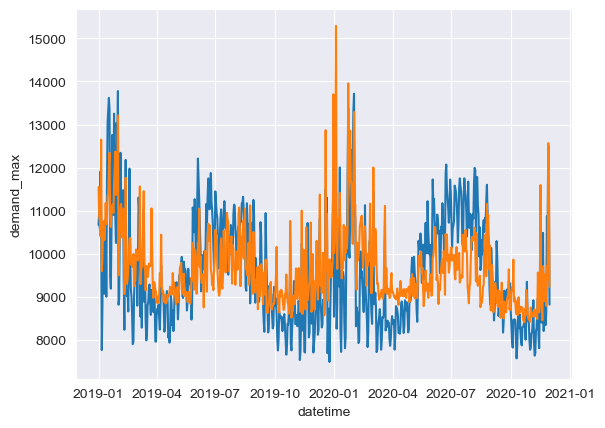

In [68]:
sns.lineplot(data=test_df, x='datetime', y='demand_max')
sns.lineplot(data=lm4_max.predict(norm_test_df))

<Axes: xlabel='datetime', ylabel='demand_min'>

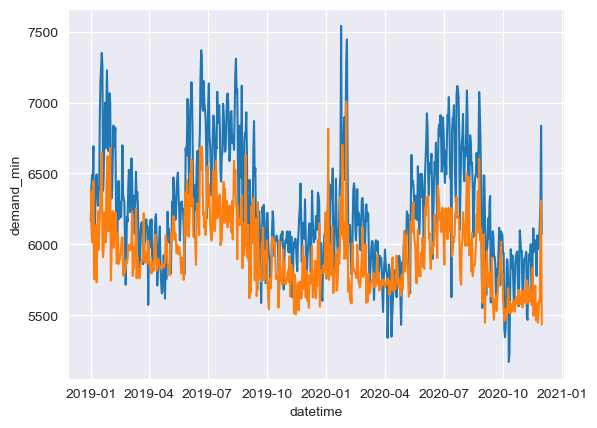

In [70]:
sns.lineplot(data=test_df, x='datetime', y='demand_min')
sns.lineplot(data=lm2_min.predict(test_df))